# Pretraining ViT-MAE on GOES Satellite Data

In this tutorial, we’ll guide you through the process of pretraining a masked autoencoder (MAE) built on a Vision Transformer (ViT) using 10 weeks of GOES-16 satellite data. GOES-16, a satellite that picks up continuous imagery and atmospheric measurements of Earth's Western Hemisphere, carries the Advanced Baseline Imager (ABI), a 16-band radiometer with spectral bands covering visible, near-infrared, and IR portions of the electromagnetic spectrum. These bands capture complex, high-dimensional patterns in the atmosphere, including cloud motion, temperature gradients, and convective activity. We will go into more detail on each of the different bands later on, but to learn more, read [A Closer Look at the ABI on the GOES-R Series](https://journals.ametsoc.org/view/journals/bams/98/4/bams-d-15-00230.1.xml). 

Before diving into supervised learning tasks in climate and Earth science, it’s critical to first build a model that truly understands the structure of the data itself even without labels. Due to the complexity of the data, making sense of these patterns requires a model that can learn these spatial representations. We will adopt a self-supervised learning approach, meaning the model learns directly from the data without human labels by solving a proxy task, which our specific use case will be reconstructing masked patches. The payoff is a reusable encoder that transfers to downstream problems with minimal labeled data, such as time-of-day inference, cloud-type classification, extreme-weather detection, or precipitation proxies.

In this context, our goal is to pretrain a Vision Transformer (ViT) using a Masked Autoencoder (MAE) approach. We will be using a vision transformer backbone because it treats an image as a sequence of fixed-size patches, flowing through stacked multi-head self-attention and feed forward blocks. This allows the model to capture long-range spatial dependencies, which is exactly what we need for satellite datasets, where the mesoscale patterns span hundreds of kilometers. On top of this backbone, we adopt masked autoencoding, which will randomly mask a large fraction of patches and train the model to reconstruct the missing patches from the visible ones. This self-supervised objective creates its own labels pushing the encoder to learn to learn underlying spatial patterns. 

To begin, we'll start off by installing and importing the essential frameworks, including the libraries mentioned prior, the ViT-MAE Hugging Face transformer, and core PyTorch modules. 

In [1]:
%%capture

# installing additional libraries into kernel 
%pip install -q "numcodecs[pcodec]==0.15.1" "xarray==2025.3.1" "zarr==3.0.6" "datashader"
%pip install -q "transformers==4.32" "datasets" "torch" "accelerate" "torchvision"

In [2]:
%%capture 

# filter warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module=r"numcodecs\.zarr3")

# scientific computing
import random
import numpy as np
import xarray as xr
import datashader as dsh
import datashader.transfer_functions as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
from PIL import Image

# PyTorch and ViT transformer
import os
import torch
from torch.optim import AdamW
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from transformers import ViTImageProcessor, ViTMAEForPreTraining, ViTMAEConfig
from accelerate import Accelerator

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/marble/share/proj failed


In addition to `numpy` and `xarray`, we are installing PyTorch and Hugging Face’s `ViTMAEForPreTraining`. PyTorch is the deep-learning engine we’ll use for training and optimization. `ViTMAEForPreTraining` provides a ready-made Vision Transformer with the masked-autoencoder objective, so we won’t have to implement ViT blocks or the masking and reconstruction logic ourselves. 

# Loading Data

In [3]:
# set configs
zarr_path = "/notebook_dir/public/mickellals-public/goes-16-2003-10-weeks.tmp.zarr"
band = "CMI_C13" 
lat_range = [-60, 60] # set to None to disable
lon_range = [-125, -25] # set to None to disable

Here, we point to the GOES-16 Zarr dataset, select the ABI band that we want to use (band 13 in this case), and crop the dataset slightly to avoid the `NaN` values. 

In [4]:
ds = xr.open_zarr(zarr_path)
# readjusting the coordinates
ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180).sortby('lon') 
# slicing data if necessary
if lat_range is not None and lon_range is not None:
    sliced = ds.sel(lat=slice(*lat_range), lon=slice(*lon_range))

# specifying the channel we want to utilize and displaying the data
cube = sliced[band]
cube

<xarray.DataArray 'CMI_C13' (t: 1680, lat: 5998, lon: 4999)> Size: 403GB
dask.array<getitem, shape=(1680, 5998, 4999), dtype=float64, chunksize=(24, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 24kB -59.98 -59.96 -59.94 ... 59.94 59.96 59.98
  * lon      (lon) float32 20kB -125.0 -125.0 -125.0 ... -25.05 -25.03 -25.01
Attributes:
    central_band_wavelength:  10.33
    long_name:                ABI Cloud and Moisture Imagery brightness tempe...
    standard_name:            toa_brightness_temperature
    descriptive_name:         clean longwave window
    valid_range:              [89.62, 341.27]
    units:                    K
    grid_mapping:             crs

This is the cubed dataset that we are working with, and it is structured in `(t, lat, lon) = (1680, 5998, 4999)`, which means the time spans 1680 hourly time frames (ten weeks), with spatial coverage from 60° S to 60° N in latitude and 125° W to 25° W in longitude (cropped above). A single pixel in the dataset represents the brightness temperature that is recorded at that location and time, which is measuered in Kelvin (K) with a valid range of `[89.62, 341.27]`.

It is the GOES-16 Cloud and Moisture Imagery brightness temperature at top of atmosphere (Band 13), which is the clean long-wave infrared window centered at approximately 10.33 µm for central wavelength. It captures the cloud and moisture imagery, hurricane intensity, legacy vertical moisture and temperature profile, derived stability indices, total precipitable water, snow cover, sea surface temperature, and radiances making it ideal for tracking true surface temperature. 

# Exploratory Data Analysis

In [5]:
# pick timestamp & build a datashader canvas

timestamp = '2023-03-11T21:05:06.337357952'
ds_ts = ds.sel(t=timestamp)

# list bands present at this timestamp (CMI_C01, ..., CMI_C16)
band_vars = sorted(list(ds_ts.data_vars))

# datashader canvas (controls rasterization resolution)
lon_min, lon_max = float(ds_ts.lon.min()), float(ds_ts.lon.max())
lat_min, lat_max = float(ds_ts.lat.min()), float(ds_ts.lat.max())
cvs = dsh.Canvas(
    plot_width=1536,      
    plot_height=768,
    x_range=(lon_min, lon_max),
    y_range=(lat_min, lat_max),
)

Here, we select a specific `timestamp` and build a Datashader Canvas over the full latitude and longitude range. The canvas lets us rasterize each `(lat, lon)` band quickly for fast, memory-efficient plotting. We will now plot every band in the dataset to better visualize the data.  

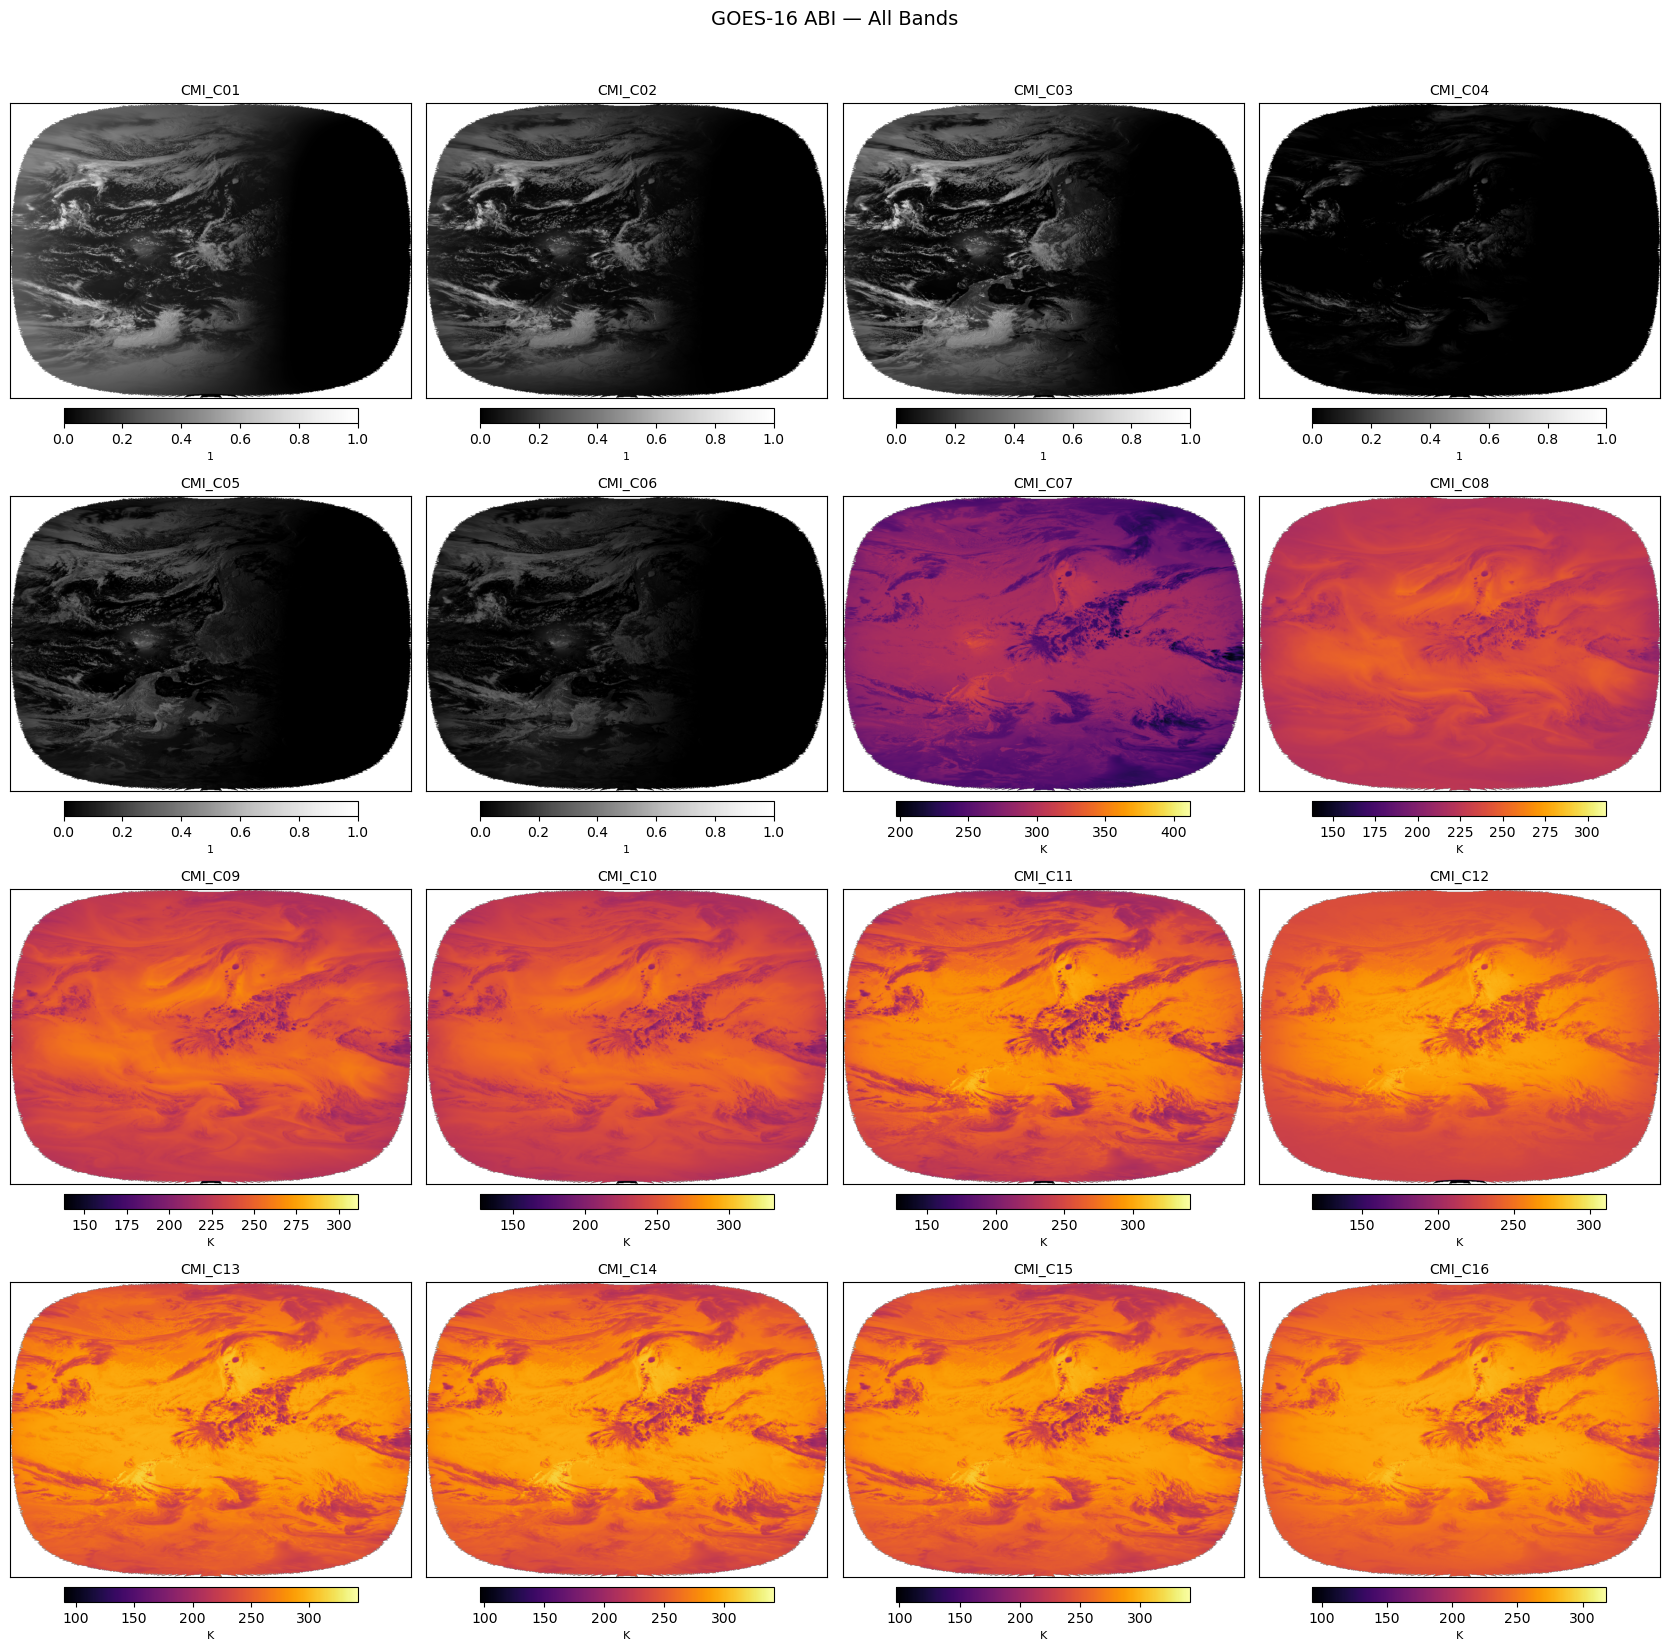

In [6]:
# fast multi-band plot 

ncols = 4
nrows = int(np.ceil(len(band_vars) / ncols))
fig = plt.figure(figsize=(4.2 * ncols, 4.2 * nrows))
fig.suptitle("GOES-16 ABI — All Bands", y=0.98, fontsize=14)

for i, var in enumerate(band_vars):
    ax = plt.subplot(nrows, ncols, i + 1)

    da = ds_ts[var].astype("float32").transpose("lat", "lon")       
    attrs = da.attrs

    # vmin/vmax directly from valid_range 
    vr = attrs.get("valid_range", None)
    if vr is not None and len(vr) == 2:
        vmin, vmax = float(vr[0]), float(vr[1])
    else:
        # very rare fallback
        vmin, vmax = np.nanpercentile(da.values, [0.5, 99.5])

    # colormap: first 6 (C01–C06) → visible/NIR → grayscale; rest → IR → inferno
    cmap_name = "Greys_r" if i < 6 else "inferno"

    # datashader needs a hex palette
    cm = mpl.colormaps[cmap_name] if hasattr(mpl, "colormaps") else mpl.cm.get_cmap(cmap_name, 256)
    palette = [mpl.colors.to_hex(cm(x), keep_alpha=False) for x in np.linspace(0, 1, 256)]

    # rasterize + shade -> PIL image
    agg = cvs.raster(da)                          # works directly with xarray DataArray
    img = tf.shade(agg, cmap=palette, span=(vmin, vmax), how="linear")

    # draw shaded image 
    ax.imshow(
        img.to_pil(),
        extent=[lon_min, lon_max, lat_min, lat_max],
        origin="lower",
        aspect="auto",
    )
    ax.set_xticks([])
    ax.set_yticks([])

    # panel title; include wavelength if available
    wv = attrs.get("band_wavelength", attrs.get("wavelength", None))
    if isinstance(wv, (list, tuple, np.ndarray)) and len(wv) == 1:
        wv = wv[0]
    title = f"{var}" if wv is None else (f"{var} ({float(wv):.1f} µm)" if np.isscalar(wv) else f"{var}")
    ax.set_title(title, fontsize=10)

    # compact colorbar using the same colormap + normalization
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap=cmap_name, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.03, fraction=0.046)
    cb.set_label(attrs.get("units", ""), fontsize=8)

# remove any unused axes if bands don't fill the grid
for j in range(len(band_vars), nrows * ncols):
    fig.delaxes(plt.subplot(nrows, ncols, j + 1))

plt.tight_layout(rect=(0, 0, 1, 0.965))
plt.show()

We're building a quick grid preview of all the GOES-16 ABI bands under one specific timestamp for the entire latitude and longitude range. The colormap is assigned by the band type with visible/NIR bands in grayscale and IR bands in the inferno color scheme. We then use Datashader to rasterize the large array and into a compact image and shade it with the colormap and normalization. 

To briefly summarize each of the bands, here are their approximate central wavelength and the descriptive name of what they capture: 
- Band 1 (0.47 µm): Blue  
- Band 2 (0.64 µm): Red
- Band 3 (0.864 µm): Vegetation
- Band 4 (1.373 µm): Cirrus
- Band 5 (1.61 µm): Snow/ice
- Band 6 (2.24 µm): Cloud particle size
- Band 7 (3.90 µm): Shortwave window
- Band 8 (6.19 µm): Upper-level water vapor
- Band 9 (6.93 µm): Midlevel water vapor
- Band 10 (7.34 µm): Lower/midlevel water vapor
- Band 11 (8.44 µm): Cloud-top phase 
- Band 12 (9.61 µm): Ozone
- Band 13 (10.33 µm): Clean longwave window
- Band 14 (11.21 µm): Longwave window
- Band 15 (12.29 µm): Dirty longwave window
- Band 16 (13.28 µm): CO₂

For pretraining this model, we chose band 13 because its clean 10.33 µm window provides physically interpretable brightness temperatures that closely track actual surface temperature along with strong thermal contrast, and it works well for both day and night. Due to the wide range and constant consistency, this band gives the self-supervised model abundant, stable features to learn, and the features themselves also open up to a variety of downstream tasks for fine-tuning later on. 

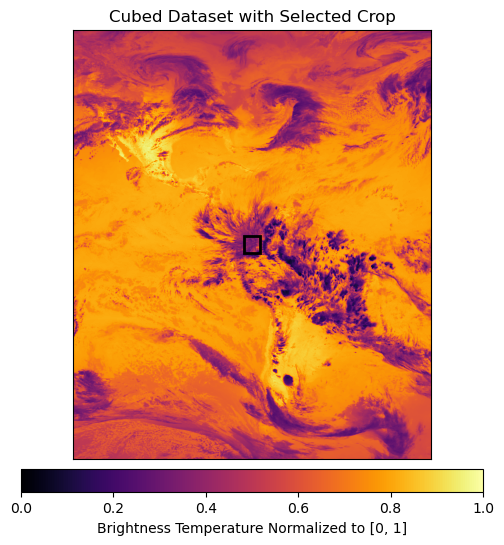

In [7]:
# configs
crop_size = 224
timestamp = '2023-03-11T21:05:06.337357952'

# load and normalize frame
frame = cube.sel(t=timestamp).values.astype(np.float32)
frame = (frame - frame.min()) / (frame.max() - frame.min())

H, W = frame.shape
# crop the center of the data at the size of crop_size
top  = (H - crop_size) // 2
left = (W - crop_size) // 2
patch = frame[top:top+crop_size, left:left+crop_size]

# plotting the dataset
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(frame, origin="lower", cmap="inferno", vmin=0.0, vmax=1.0)

# including a box that shows where we are cropping 
rect = Rectangle((left, H - top - crop_size), crop_size, crop_size,
                 fill=False, linewidth=2)
ax.add_patch(rect)
cb = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.02, fraction=0.05)
cb.set_label("Brightness Temperature Normalized to [0, 1]")
# including the title
ax.set_title(f"Cubed Dataset with Selected Crop")
ax.set_xticks([]); ax.set_yticks([])
plt.show()


We do a crop in the center of the previous cubed dataset and extract a `224 × 224` patch at a specific timestamp, which is shown with the square black box highlighting the selected crop. Then, we convert those data points to `float32` and normalize them to the range `[0, 1]` so that the pixel values can be consistently visualized using the Inferno colormap. 

# Model Configuration and Building

In [8]:
# load the pre-trained MAE model
processor = ViTImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

# convert patch to RBG format 
patch_uint8 = (patch * 255).astype(np.uint8)
pil_image = Image.fromarray(patch_uint8, mode='L')  
pil_image_rgb = pil_image.convert('RGB')  

# process with ViT preprocessor 
inputs = processor(images=pil_image_rgb, return_tensors='pt')

# train MAE model with default 75% masking
with torch.no_grad():
    outputs = model(**inputs)

# extract losses 
loss = outputs.loss
# reconstructed patches
reconstruction_logits = outputs.logits  
# boolean mask (1=masked, 0=visible)
mask = outputs.mask 

# convert reconstruction logits back to image format
reconstructed_patches = model.unpatchify(reconstruction_logits)
reconstructed_image = reconstructed_patches.squeeze(0).permute(1, 2, 0).numpy()

# denormalize the images back to [0,1] range
mean_norm = np.array([0.485, 0.456, 0.406])
std_norm = np.array([0.229, 0.224, 0.225])

# denormalize the original input
original_denorm = inputs.pixel_values.squeeze(0).permute(1, 2, 0).numpy()
for i in range(3):
    original_denorm[:, :, i] = (original_denorm[:, :, i] * std_norm[i]) + mean_norm[i]
original_final = np.clip(np.mean(original_denorm, axis=2), 0, 1)  

# denormalize the reconstruction
reconstructed_denorm = reconstructed_image.copy()
for i in range(3):
    reconstructed_denorm[:, :, i] = (reconstructed_image[:, :, i] * std_norm[i]) + mean_norm[i]
reconstructed_final = np.clip(np.mean(reconstructed_denorm, axis=2), 0, 1)  

# set the masked patches to zero
masked_input_display = original_final.copy()
# default patch size
patch_size = 16 
h, w = original_final.shape
num_patches_h = h // patch_size
num_patches_w = w // patch_size

# apply masking patch by patch
mask_2d = mask.squeeze(0).view(num_patches_h, num_patches_w).numpy()

for i in range(num_patches_h):
    for j in range(num_patches_w):
        if i * num_patches_w + j < mask.shape[1]:  
            if mask_2d[i, j] > 0.5:  
                y_start, y_end = i * patch_size, min((i + 1) * patch_size, h)
                x_start, x_end = j * patch_size, min((j + 1) * patch_size, w)
                masked_input_display[y_start:y_end, x_start:x_end] = 0

/opt/conda/envs/marble/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Here, we are pretraining the ViT-MAE transformer to reconstruct missing image patches so that it will better understand the data. First, we load the pre-trained model `ViTMAEForPreTraining` along with its associated processor `ViTImageProcessor`. The processor is responsible for resizing, normalization, and preparing the input image in the correct tensor format. Since the input patch is a normalized single-channel array, it is first scaled to 8-bit and converted into a grayscale PIL image. Because the MAE expects RGB input, the grayscale image is then expanded into three channels.

Next, the processor is used to convert this RGB image into normalized tensors suitable for the model. This is then run in inference mode `torch.no_grad()`, which applies the default 75% random patch masking. The model outputs include the reconstruction loss, which is the mean squared error over masked patches (MSE), the logits representing predicted pixel patches, and the binary mask that indicates which patches were masked. To convert these predictions back into an image, the logits are then unpatchified and reshaped into the original spatial arrangement.

Since the processor applied normalization across the dataset, both the input and reconstructed images must be denormalized to return to the `[0,1]` range. We perform this inverse normalization and then average the three identical RGB channels to recover the original grayscale representation of the GOES band. Then, the code builds a visualization of the masked input. The image is divided into `16×16` patches, and using the mask output, any patch marked as masked is replaced with zeros (black). This produces an image where visible patches remain intact while masked patches appear black, illustrating what the encoder actually receives. 

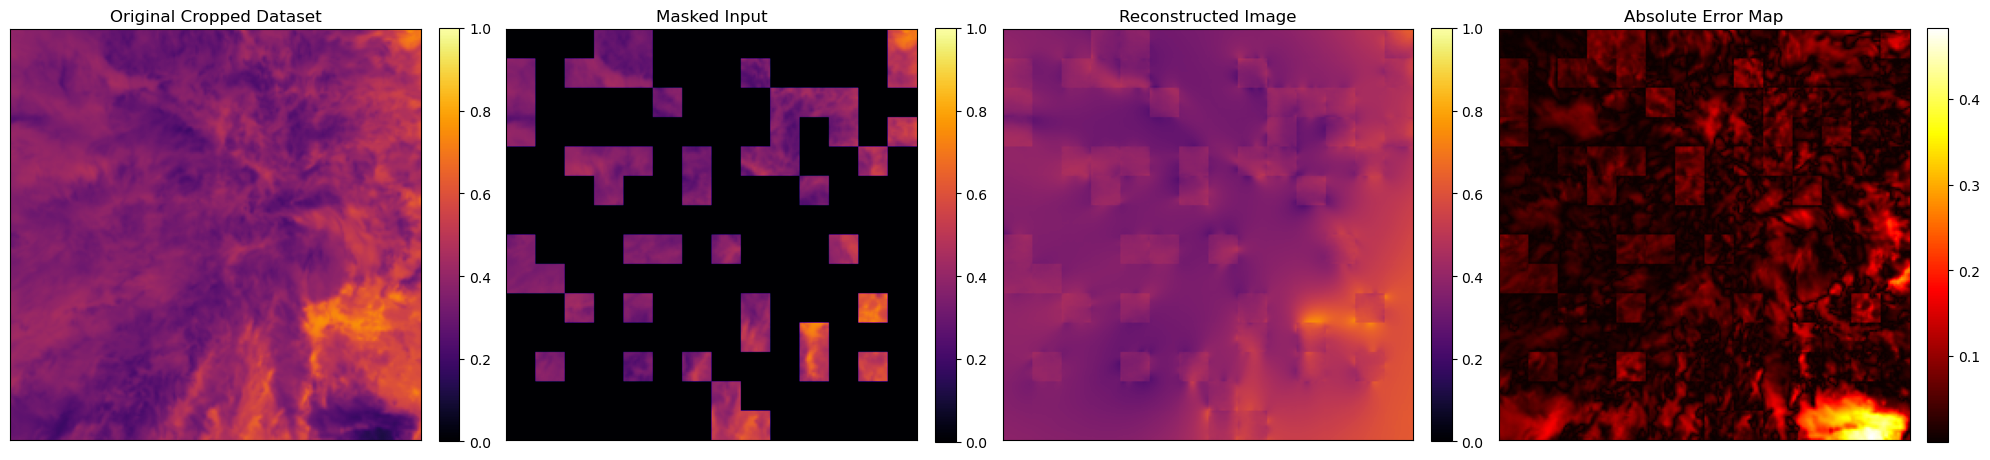


Overall Loss: 0.102069


In [9]:
# plot the critical graphs               
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# the original cropped dataset
ax = axes[0]
im1 = ax.imshow(patch, origin="lower", cmap="inferno", vmin=0.0, vmax=1.0)
ax.set_title("Original Cropped Dataset")
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

# the masked input to the encoder
ax = axes[1]
im2 = ax.imshow(masked_input_display, origin="lower", cmap="inferno", vmin=0.0, vmax=1.0)
ax.set_title(f"Masked Input")
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

# reconstruction from the model 
ax = axes[2]
im3 = ax.imshow(reconstructed_final, origin="lower", cmap="inferno", vmin=0.0, vmax=1.0)
ax.set_title("Reconstructed Image")
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

# absolute error map
ax = axes[3]
error_map = np.abs(patch - reconstructed_final)
im4 = ax.imshow(error_map, origin="lower", cmap="hot")
ax.set_title("Absolute Error Map")
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(im4, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# report the overall loss
print(f"\nOverall Loss: {loss.item():.6f}")

To visualize the training process, we generate a set of four graphs to evaluate how well this model reconstructs a cropped section of the dataset. The first image shows the baseline view of the input data, and the second image shows the 75% masked input given to the encoder, and the third image shows the reconstructed image generated by the ViT-MAE model, and the fourth image shows the absolute error map, which highlights the pixel-wise differences between the original crop and the reconstructed output, with brighter regions corresponding to higher reconstruction errors. The overall reconstruction loss is also reported, which is calculated by the vision transformer, which corresponds to the mean squared error (MSE) between the reconstructed and original patches. 

# Limitations and Final Remarks

Due to memory limitations, I wasn't able to display the walkthrough for pretraining the entire dataset over multiple time steps. 